Optimization started...


100%|██████████| 15000/15000 [00:36<00:00, 406.31it/s, init loss: 26448.0234, avg. loss [14251-15000]: -4664.3521]



SVI elapsed time: 38.48139047622681


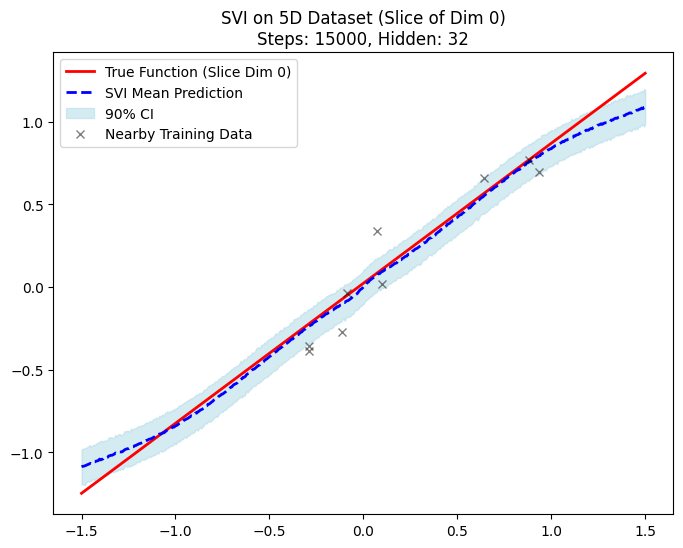

------------------------------
Final Evaluation (5D SVI):
Accuracy (RMSE):   0.0632 (Closer to 0 is better)
Calibration (90%): 87.60% (Should be near 90%)
------------------------------


In [14]:
import time
import matplotlib.pyplot as plt
import numpy as np
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal
import numpyro.distributions as dist
from jax import jit
# 1. Define the same BNN model (No changes needed here!)
def nonlin(x):
    return jnp.tanh(x)

def model(X, Y, D_H, D_Y=1):
    N, D_X = X.shape
    
    # Standard BNN layers
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    z1 = nonlin(jnp.matmul(X, w1))
    
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    z2 = nonlin(jnp.matmul(z1, w2))
    
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    z3 = jnp.matmul(z2, w3)
    
    # Observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)
    
    # Observe data
    with numpyro.plate("data", N, subsample_size=N): # Note: subsample_size can be used for mini-batching
        numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

# 2. SVI Training Function
def run_svi(model, args, rng_key, X, Y, D_H):
    start = time.time()
    
    # A. The Guide: Automatically approximates the posterior as a Normal distribution
    guide = AutoLowRankMultivariateNormal(model, rank = 10)
    
    # B. The Optimizer: Adam is standard for SVI
    optimizer = numpyro.optim.Adam(step_size=args.learning_rate)
    
    # C. The Loss: ELBO (Evidence Lower Bound)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # D. Run the optimization loop
    print("Optimization started...")
    svi_result = svi.run(rng_key, args.num_steps, X, Y, D_H)
    print("\nSVI elapsed time:", time.time() - start)
    
    # Return the learned variational parameters (means and stds of the weights)
    return svi_result.params, guide

# 3. Data Generation (Updated for 5D)
def get_data_5d(N=1000, D_X=5, sigma_obs=0.05, N_test=500):
    np.random.seed(0)
    
    # Create random weights for a "True" linear component
    W_true = np.random.randn(D_X) 
    
    def true_function(X_in):
        # A complex function: Linear combination + Non-linear interaction of first 2 dims
        linear_part = jnp.dot(X_in, W_true)
        # We only add non-linearity to the first two dimensions for visualization
        nonlinear_part = 0.5 * jnp.cos(3 * X_in[:, 0]) * jnp.sin(2 * X_in[:, 1])
        return linear_part + nonlinear_part

    # Generate random 5D input data
    X = np.random.rand(N, D_X) * 2 - 1  # Range [-1, 1]
    Y = true_function(X)
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    
    # Standardization (Critical for SVI convergence!)
    mu_Y, std_Y = jnp.mean(Y), jnp.std(Y)
    Y = (Y - mu_Y) / std_Y
    
    # Test data (Slice across Dimension 0, keep others fixed at 0)
    # This allows us to visualize a 1D slice of the 5D function
    X_test = np.zeros((N_test, D_X))
    X_test[:, 0] = np.linspace(-1.5, 1.5, N_test) # Vary dim 0
    # You can set other dims to random fixed values if you want
    
    # True Y for Test Data
    Y_test_true = true_function(X_test)[:, np.newaxis]
    Y_test_true = (Y_test_true - mu_Y) / std_Y
    
    return jnp.array(X), jnp.array(Y), jnp.array(X_test), jnp.array(Y_test_true)

def main(args):
    # Get 5D Data
    X, Y, X_test, Y_test_true = get_data_5d(N=args.num_data, D_X=5)
    
    # Run SVI
    rng_key, rng_predict = random.split(random.PRNGKey(0))
    svi_params, guide = run_svi(model, args, rng_key, X, Y, args.num_hidden)
    
    # Make Predictions using 'Predictive' utility
    # We sample 1000 possible networks from our trained Guide
    predictive = Predictive(model, guide=guide, params=svi_params, num_samples=1000)

    @jit
    def get_predictions(rng_key,X_test):
        return predictive(rng_key, X_test, None, args.num_hidden)["Y"]
    samples = get_predictions(rng_predict, X_test)
    
    # Calculate statistics
    mean_prediction = jnp.mean(samples, axis=0)[..., 0]
    percentiles = np.percentile(samples, [5.0, 95.0], axis=0)[..., 0]
    
    # Plotting (Slice of Dimension 0)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot true function (Red Line)
    ax.plot(X_test[:, 0], Y_test_true, "r-", label="True Function (Slice Dim 0)", lw=2)
    
    # Plot Mean Prediction (Blue Line)
    ax.plot(X_test[:, 0], mean_prediction, "b--", label="SVI Mean Prediction", lw=2)
    
    # Plot Uncertainty (Shaded Area)
    ax.fill_between(X_test[:, 0], percentiles[0], percentiles[1], color="lightblue", alpha=0.5, label="90% CI")
    
    # Plot Training Data (Only points close to the slice plane for clarity)
    # We filter for points where other dimensions are close to 0
    mask = np.abs(X[:, 1:]).max(axis=1) < 0.2
    if mask.sum() > 0:
        ax.plot(X[mask, 0], Y[mask, 0], "kx", alpha=0.5, label="Nearby Training Data")
        
    ax.set_title(f"SVI on 5D Dataset (Slice of Dim 0)\nSteps: {args.num_steps}, Hidden: {args.num_hidden}")
    ax.legend()
    plt.show()
    # ... after your plotting code ...

    # 1. Flatten arrays for comparison
    # mean_prediction shape: (500,)
    # Y_test_true shape: (500, 1) -> flatten to (500,)
    truth = Y_test_true.flatten()
    pred = mean_prediction.flatten()
    
    # 2. Accuracy (RMSE)
    rmse = jnp.sqrt(jnp.mean((pred - truth)**2))
    
    # 3. Calibration (Coverage)
    # Check what % of true points fall inside the 90% CI
    lower = percentiles[0].flatten()
    upper = percentiles[1].flatten()
    inside = (truth >= lower) & (truth <= upper)
    coverage = jnp.mean(inside)
    
    print("-" * 30)
    print(f"Final Evaluation (5D SVI):")
    print(f"Accuracy (RMSE):   {rmse:.4f} (Closer to 0 is better)")
    print(f"Calibration (90%): {coverage:.2%} (Should be near 90%)")
    print("-" * 30)

# Configuration
class Args:
    num_data = 5000       # SVI handles large data better than MCMC
    num_hidden = 32      # Neurons
    learning_rate = 5e-3  # Standard for Adam
    num_steps = 15000     # Optimization steps (not samples!)

args = Args()
main(args)